In [97]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import seaborn as sns
from dotenv import dotenv_values
import warnings
from scipy.stats import mannwhitneyu
import plotly.express as px
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import root_mean_squared_log_error, mean_absolute_error, root_mean_squared_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
import itertools
import pickle


warnings.filterwarnings("ignore")


In [98]:
#loading environment variables
environment_variables = dotenv_values(r"C:\Users\hp\Desktop\lp3\Time-series-Regression-Analysis\.env")
#get values from the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
#create connection string
connection_string = f"DRIVER={{SQL Server}}; DATABASE={database}; SERVER={server}; UID={username}; PWD={password}"

In [99]:
connection = pyodbc.connect(connection_string)

In [100]:
#select tables from database
db_query = ''' SELECT *
            FROM INFORMATION_SCHEMA.TABLES
            WHERE TABLE_TYPE = 'BASE TABLE' '''


In [101]:
#call tables from database
ata = pd.read_sql(db_query, connection)
ata

TABLE_CATALOG TABLE_SCHEMA       TABLE_NAME  TABLE_TYPE
0         dapDB          dbo  holidays_events  BASE TABLE
1         dapDB          dbo              oil  BASE TABLE
2         dapDB          dbo           stores  BASE TABLE

In [102]:
#loading data from database
query_01 = "select * FROM dbo.holidays_events"
data_1_holidays = pd.read_sql(query_01, connection)

query_02 = "select * FROM dbo.oil"
data_1_oil= pd.read_sql(query_02,connection)

query_03 = "select * FROM dbo.stores"
data_1_stores = pd.read_sql(query_03,connection)




In [103]:
data_1_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [104]:
data_1_holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [105]:
#converting the date column to a datetime
data_1_holidays['date'] = pd.to_datetime(data_1_holidays['date'], format = '%Y-%m-%d')

In [106]:
data_1_holidays

date        type    locale locale_name  \
0   2012-03-02     Holiday     Local       Manta   
1   2012-04-01     Holiday  Regional    Cotopaxi   
2   2012-04-12     Holiday     Local      Cuenca   
3   2012-04-14     Holiday     Local    Libertad   
4   2012-04-21     Holiday     Local    Riobamba   
..         ...         ...       ...         ...   
345 2017-12-22  Additional  National     Ecuador   
346 2017-12-23  Additional  National     Ecuador   
347 2017-12-24  Additional  National     Ecuador   
348 2017-12-25     Holiday  National     Ecuador   
349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [107]:
data_1_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [108]:
#converting the date column
data_1_oil['date'] = pd.to_datetime(data_1_oil['date'], format = '%Y-%m-%d')

In [109]:
data_1_oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997

In [110]:
data_1_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [111]:
# # Interpolate missing oil prices
# data_1_oil['dcoilwtico'] = data_1_oil['dcoilwtico'].interpolate(method='linear', inplace=True)


In [112]:
data_1_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [113]:
data_1_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [114]:
##loading the transactions dataset
data_2_transactions = pd.read_csv(r'C:\Users\hp\Desktop\lp3\Time-series-Regression-Analysis\datasets\transactions.csv')

In [115]:
data_2_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [116]:
#converting the date column to datewtime format
data_2_transactions['date'] = pd.to_datetime(data_2_transactions['date'], format = '%Y-%m-%d')

In [117]:
data_2_transactions.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [118]:
#loading the train dataset
train_data = pd.read_csv(r'C:\Users\hp\Desktop\lp3\Time-series-Regression-Analysis\datasets\train.csv')

In [119]:
train_data

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [120]:
train_data['date'] = pd.to_datetime(train_data['date'],format = '%Y-%m-%d')

In [121]:
#the id column wont be necessary for our analysis
train_data = train_data.drop(['id'], axis = 1)


In [122]:
train_data.head()

date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0            0
1 2013-01-01          1   BABY CARE    0.0            0
2 2013-01-01          1      BEAUTY    0.0            0
3 2013-01-01          1   BEVERAGES    0.0            0
4 2013-01-01          1       BOOKS    0.0            0

In [123]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 114.5+ MB


In [124]:
train_data_mrg1 = pd.merge(train_data, data_1_holidays, on='date', how='left')
train_data_mrg1.head()

date  store_nbr      family  sales  onpromotion     type    locale  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday  National   
1 2013-01-01          1   BABY CARE    0.0            0  Holiday  National   
2 2013-01-01          1      BEAUTY    0.0            0  Holiday  National   
3 2013-01-01          1   BEVERAGES    0.0            0  Holiday  National   
4 2013-01-01          1       BOOKS    0.0            0  Holiday  National   

  locale_name         description transferred  
0     Ecuador  Primer dia del ano       False  
1     Ecuador  Primer dia del ano       False  
2     Ecuador  Primer dia del ano       False  
3     Ecuador  Primer dia del ano       False  
4     Ecuador  Primer dia del ano       False

In [125]:
train_data_mrg2 = pd.merge(train_data_mrg1, data_1_oil, on='date', how='left')
train_data_mrg2.head()

date  store_nbr      family  sales  onpromotion     type    locale  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday  National   
1 2013-01-01          1   BABY CARE    0.0            0  Holiday  National   
2 2013-01-01          1      BEAUTY    0.0            0  Holiday  National   
3 2013-01-01          1   BEVERAGES    0.0            0  Holiday  National   
4 2013-01-01          1       BOOKS    0.0            0  Holiday  National   

  locale_name         description transferred  dcoilwtico  
0     Ecuador  Primer dia del ano       False         NaN  
1     Ecuador  Primer dia del ano       False         NaN  
2     Ecuador  Primer dia del ano       False         NaN  
3     Ecuador  Primer dia del ano       False         NaN  
4     Ecuador  Primer dia del ano       False         NaN

In [126]:
train_data_mrg3 = pd.merge(train_data_mrg2, data_1_stores, on='store_nbr', how='left')
train_data_mrg3.head()

date  store_nbr      family  sales  onpromotion   type_x    locale  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday  National   
1 2013-01-01          1   BABY CARE    0.0            0  Holiday  National   
2 2013-01-01          1      BEAUTY    0.0            0  Holiday  National   
3 2013-01-01          1   BEVERAGES    0.0            0  Holiday  National   
4 2013-01-01          1       BOOKS    0.0            0  Holiday  National   

  locale_name         description transferred  dcoilwtico   city      state  \
0     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
1     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
2     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
3     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
4     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   

  type_y  cluster  
0      D       13  
1      D       13  
2      D       13  
3      D       13  
4      D       13

In [127]:
train_data_mrg_final = pd.merge(train_data_mrg3, data_2_transactions, on=['date', 'store_nbr'], how='left')
train_data_mrg_final.head()

date  store_nbr      family  sales  onpromotion   type_x    locale  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday  National   
1 2013-01-01          1   BABY CARE    0.0            0  Holiday  National   
2 2013-01-01          1      BEAUTY    0.0            0  Holiday  National   
3 2013-01-01          1   BEVERAGES    0.0            0  Holiday  National   
4 2013-01-01          1       BOOKS    0.0            0  Holiday  National   

  locale_name         description transferred  dcoilwtico   city      state  \
0     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
1     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
2     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
3     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   
4     Ecuador  Primer dia del ano       False         NaN  Quito  Pichincha   

  type_y  cluster  transactions  
0      D       13           NaN  
1      D       13           NaN  
2      D       13           NaN  
3      D       13           NaN  
4      D       13           NaN

In [128]:
train_data_mrg_final.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
city                  0
state                 0
type_y                0
cluster               0
transactions     249117
dtype: int64

**Analysis of Null Values**
- type_x, locale, locale_name, description, transferred:
Null Count: 2,551,824
Possible Cause: These columns likely come from a join with the holidays/events dataset. If there were no holidays/events on certain dates, these fields would be null.
Action:null values indicate the absence of a holiday/event and handle accordingly (e.g., fill with a default value indicating no event).

- dcoilwtico:
Null Count: 955,152
Possible Cause: Missing oil price data for certain dates.
Action: Interpolate or fill missing values using forward fill, backward fill, or another appropriate method.

- transactions:
Null Count: 249,117
Possible Cause: Missing transaction data for certain dates and stores.
Action: Fill with zero if it makes sense to assume no transactions occurred

#### *Univariate Analysis*

In [129]:
# Example: Identify numerical and categorical columns
numerical_cols = ['sales', 'transactions', 'dcoilwtico']
categorical_cols = ['store_nbr', 'family', 'onpromotion', 'type_x', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'type_y', 'cluster']
categorical_cols = ['store_nbr', 'family', 'onpromotion', 'type_x', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'type_y', 'cluster']


In [130]:
# Summary statistics for numerical variables
numerical_summary = train_data_mrg_final[numerical_cols].describe().T
print(numerical_summary)


                  count         mean          std        min      25%  \
sales         3054348.0   359.020892  1107.285897   0.000000     0.00   
transactions  2805231.0  1697.071441   966.831652   5.000000  1046.00   
dcoilwtico    2099196.0    68.015874    25.691342  26.190001    46.41   

                  50%          75%            max  
sales           11.00   196.011000  124717.000000  
transactions  1395.00  2081.000000    8359.000000  
dcoilwtico      53.43    95.809998     110.620003  


- **Sales**: There is a wide range of sales values, with a significant number of days having low sales and some days with exceptionally high sales, potentially indicating seasonal or promotional spikes.
- **Transactions**: Daily transactions also vary widely, with some days seeing very few transactions and others seeing a high volume, reflecting varying customer traffic.
- **dcoilwtico**: Oil prices fluctuate throughout the period, which could impact consumer behavior and purchasing power, especially in contexts where oil prices influence overall economic conditions.

#### **Hypothesis Testing using T-Test**

A t-test is a statistical method used to determine if there is a significant difference between the means of two groups. It evaluates whether the observed differences between the sample means are likely due to random chance or are statistically significant.
**Hypothesis:**


**Null Hypothesis (H0):** There is no significant impact of promotions on the sales of products.

**Alternative Hypothesis (H1):** There is a significant impact of promotions on the sales of products.

In [131]:
#split onpromotion variable into promoted and non-promoted
promoted_sales = train_data_mrg_final[train_data_mrg_final['onpromotion'] >= 1]['sales']

non_promoted_sales = train_data_mrg_final[train_data_mrg_final['onpromotion'] == 0]['sales']


In [132]:
#I performed a Mann-Whitney U test since it does not assume normality

# Perform Mann-Whitney U Test
stat, p = mannwhitneyu(promoted_sales, non_promoted_sales)
print('Mann-Whitney U Test: Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretation
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis - There is a significant difference in sales between promoted and non-promoted products.")
else:
    print("Fail to reject the null hypothesis - There is no significant difference in sales between promoted and non-promoted products.")



Mann-Whitney U Test: Statistics=1325737417943.500, p=0.000
Reject the null hypothesis - There is a significant difference in sales between promoted and non-promoted products.


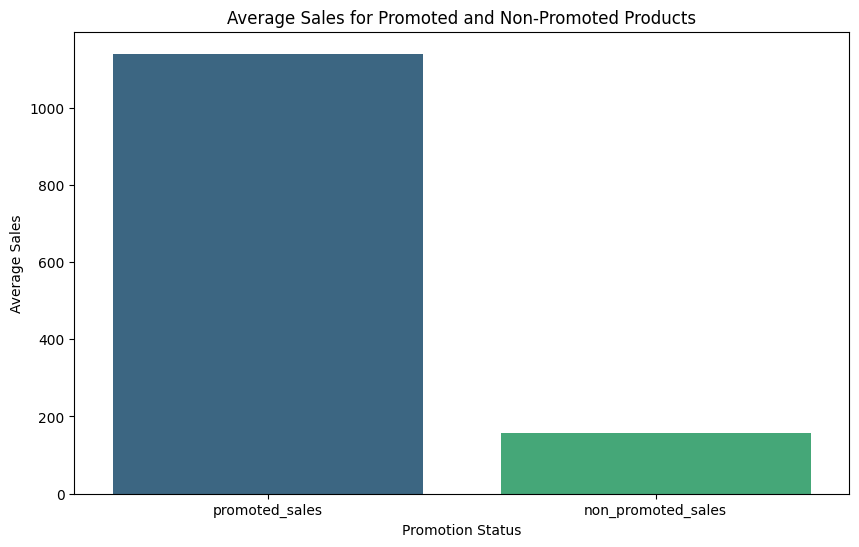

In [133]:
#visualising the average sales

#calculating average sales for promoted and non-promoted products
average_promoted_sales = promoted_sales.mean()
average_non_promoted_sales = non_promoted_sales.mean()

#plotting
plt.figure(figsize = (10,6))
sns.barplot(x = ['promoted_sales', 'non_promoted_sales'], y = [average_promoted_sales, average_non_promoted_sales],palette='viridis')
plt.xlabel('Promotion Status')
plt.ylabel('Average Sales')
plt.title('Average Sales for Promoted and Non-Promoted Products')
plt.show()

## Answering Analytical Questions

### **Question 1**
### **Is the train dataset complete (has all the required dates)?**

In [134]:
#get start and end datae
start_date = train_data['date'].min()
end_date = train_data['date'].max()

#create a complete date range
complete_date_range = pd.date_range(start = start_date, end = end_date)

#check for missing dates
missing_dates = complete_date_range.difference(train_data['date'])

#output results
print(f"Date range in the dataset: {start_date} to {end_date}")
print(f"Number of missing dates is: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("missing dates:")
    print(missing_dates)
else:
    print("The dataset has all the required dates")

Date range in the dataset: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Number of missing dates is: 4
missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


### Insights
Possible Interpretations for Missing Dates
- Holiday Closures:
The missing dates (December 25) correspond to Christmas Day. It's common for stores to be closed or have reduced operations on major holidays. The absence of data on these dates might reflect that the stores were closed or had no sales recorded on these days.
- Business Operations:
The stores might have different operating schedules during holidays or special periods, leading to lower or no sales recorded. Understanding the store's operational schedule can provide insights into these gaps.


### **Question 2**
### **Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**

In [135]:
#I assumed that on days sales were 0, the store was closed

# Extract the year from the 'date' column
train_data_mrg_final['year'] = train_data_mrg_final['date'].dt.year

# Group by year and calculate min and max sales
yearly_sales_stats = train_data_mrg_final.groupby('year')['sales'].agg([('min_sales', 'min'), ('max_sales', 'max')])

# Filter out days with sales of 0
filtered_data = train_data_mrg_final[train_data_mrg_final['sales'] != 0]

# Find the dates with lowest and highest sales for each year in the filtered data
lowest_sales_dates = filtered_data.loc[filtered_data.groupby('year')['sales'].idxmin(), ['year', 'date', 'sales']]
highest_sales_dates = train_data_mrg_final.loc[train_data_mrg_final.groupby('year')['sales'].idxmax(), ['year', 'date', 'sales']]

# Sort the highest sales dates by sales in descending order
highest_sales_dates_sorted = highest_sales_dates.sort_values(by='sales', ascending=False)


# Display the results
print("\nDates with the lowest sales for each year (excluding days with sales of 0):")
print(lowest_sales_dates)

print("\nDates with the highest sales for each year:")
print(highest_sales_dates_sorted)



Dates with the lowest sales for each year (excluding days with sales of 0):
         year       date  sales
394910   2013 2013-08-06  0.122
1268090  2014 2014-12-05  0.188
1781306  2015 2015-09-15  0.196
2292278  2016 2016-06-23  0.396
2712830  2017 2017-02-09  0.426

Dates with the highest sales for each year:
         year       date       sales
2194017  2016 2016-05-02  124717.000
569724   2013 2013-11-12   46271.000
1273284  2014 2014-12-08   45361.000
1941534  2015 2015-12-14   40351.460
2806629  2017 2017-04-02   38422.625


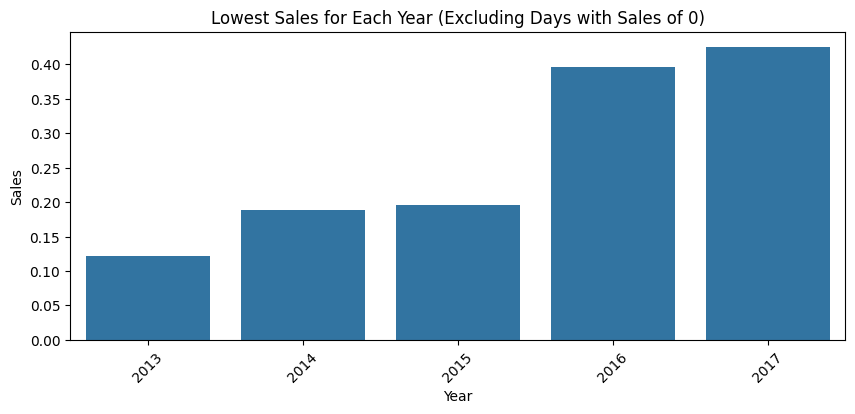

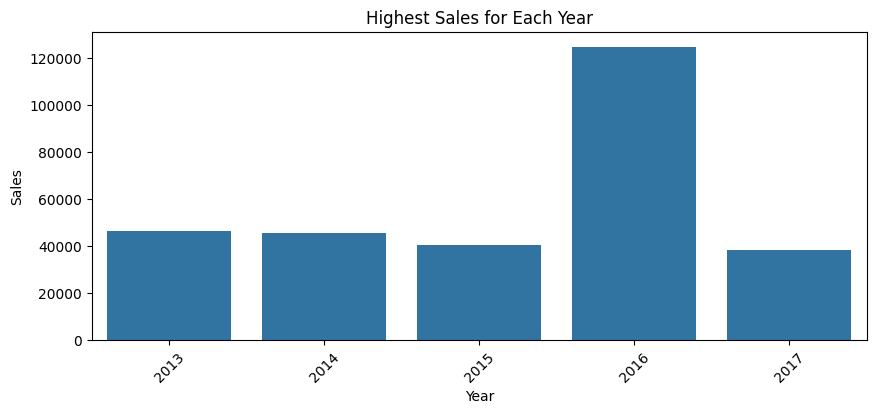

In [136]:
# Plot the dates with the lowest sales for each year
plt.figure(figsize=(10, 4))
sns.barplot(x='year', y='sales', data=lowest_sales_dates)
plt.title('Lowest Sales for Each Year (Excluding Days with Sales of 0)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

# Plot the dates with the highest sales for each year
plt.figure(figsize=(10, 4))
sns.barplot(x='year', y='sales', data=highest_sales_dates_sorted)
plt.title('Highest Sales for Each Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

**Key Insights**
Lowest Sales Trends:

- The dates with the lowest sales each year generally have very low sales figures, all below 0.5.
These dates are scattered throughout the year with no clear seasonal trend. They fall in different months and do not show a consistent pattern, indicating that the lowest sales days might be due to isolated events or specific store issues rather than seasonal factors.
These low sales figures might correspond to specific holidays, weekdays with historically low foot traffic, or could be influenced by specific events that deter shopping (e.g., severe weather).
- Highest Sales Trends:
The highest sales dates are significantly higher than the lowest sales dates, showing a stark contrast. The highest sales figures range from around 38,000 to over 124,000.
The date with the highest sales in 2016 (May 2) is notably high, suggesting a major event or promotion driving sales on that particular day. This could be related to a special store event, a major holiday, or a significant promotion.
Other high sales dates (November and December) coincide with the holiday shopping season, which is expected to have higher sales due to Christmas and other year-end festivities.
April (for 2017) and May (for 2016) high sales dates might correspond with seasonal promotions, such as spring sales or other marketing activities.
- Yearly Comparison:
The highest sales in 2016 are much higher compared to other years, indicating an exceptionally successful sales day. This might warrant a deeper look into the promotional activities or external factors that contributed to this peak.
There is a consistent pattern of the highest sales occurring towards the end of the year, except for 2016 and 2017. This is likely influenced by holiday shopping.
The variation in the dates with the highest sales suggests different peak times for sales across the years, indicating changing shopping behaviors or promotional strategies.

### **Question 3**
### **Compare the sales for each month across the years and determine which month of which year had the highest sales.**

The month with the highest sales is 12.0 of 2016.0 with total sales of 30776136.97


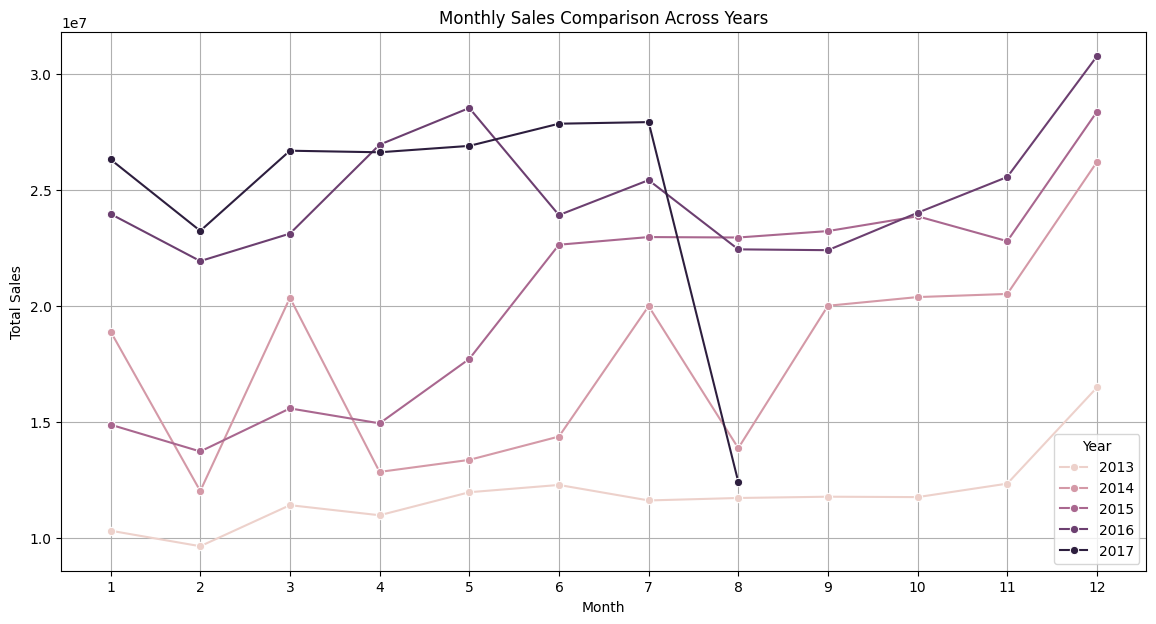

In [137]:
# Extract the year and month from the 'date' column
train_data_mrg_final['year'] = train_data_mrg_final['date'].dt.year
train_data_mrg_final['month'] = train_data_mrg_final['date'].dt.month

# Group by year and month, then calculate the total sales for each month of each year
monthly_sales = train_data_mrg_final.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month and year with the highest sales
highest_monthly_sales = monthly_sales.loc[monthly_sales['sales'].idxmax()]

# Display the results
print(f"The month with the highest sales is {highest_monthly_sales['month']} of {highest_monthly_sales['year']} with total sales of {highest_monthly_sales['sales']:.2f}")

# Visualize the monthly sales across the years
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', marker='o')

plt.title('Monthly Sales Comparison Across Years')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)
plt.show()


In [138]:
#Filter sales data for the periods before and after the earthquake
sales_before_earthquake = train_data_mrg_final[train_data_mrg_final['date'] < '2016-04-16']
sales_after_earthquake = train_data_mrg_final[train_data_mrg_final['date'] >= '2016-04-16']

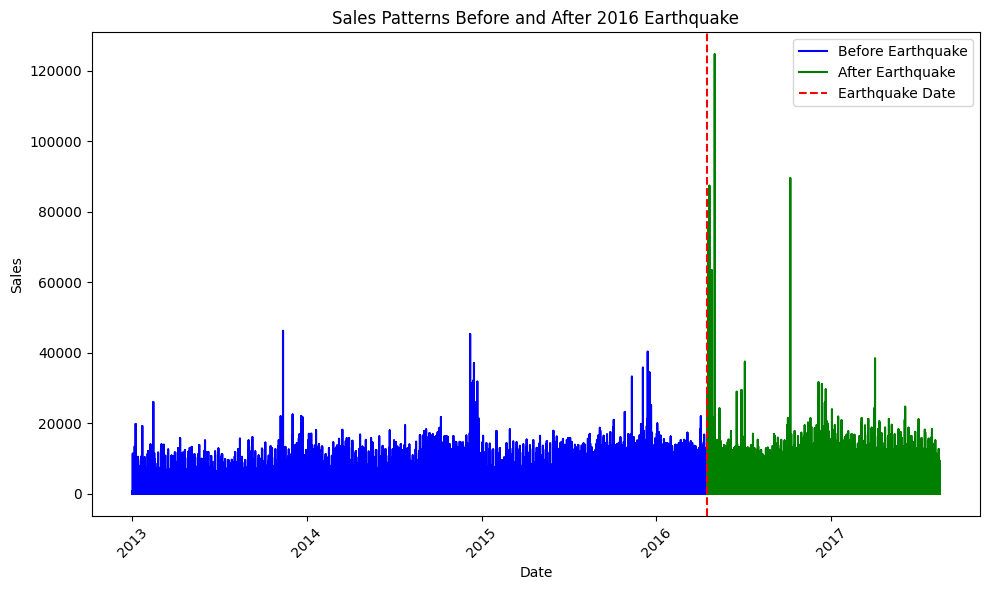

In [139]:
#Create a line plot for sales trends before and after the earthquake
plt.figure(figsize=(10, 6))
plt.plot(sales_before_earthquake['date'], sales_before_earthquake['sales'], label='Before Earthquake', color='blue')
plt.plot(sales_after_earthquake['date'], sales_after_earthquake['sales'], label='After Earthquake', color='green')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake Date')
plt.title('Sales Patterns Before and After 2016 Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [140]:
#Filter data around earthquake date
earthquake_date = pd.to_datetime('2016-04-16')
window_days = 14  # Number of days before and after the earthquake
start_date_before = earthquake_date - pd.DateOffset(days=window_days)
end_date_before = earthquake_date
start_date_after = earthquake_date
end_date_after = earthquake_date + pd.DateOffset(days=window_days)

data_before_earthquake = train_data_mrg_final[
    (train_data_mrg_final['date'] >= start_date_before) & (train_data_mrg_final['date'] <= end_date_before)
]
data_before_earthquake['group'] = 'Before Earthquake'

data_after_earthquake = train_data_mrg_final[
    (train_data_mrg_final['date'] >= start_date_after) & (train_data_mrg_final['date'] <= end_date_after)
]
data_after_earthquake['group'] = 'After Earthquake'

#Concatenate the dataframes
combined_data = pd.concat([data_before_earthquake, data_after_earthquake])

#Create Plotly figure
fig = px.line(combined_data, x='date', y='sales', color='group', title='Sales Patterns Before and After 2016 Earthquake')

#Add vertical line to indicate earthquake date
fig.add_vline(x=earthquake_date, line_dash="dash", line_color="red", name="2016 Earthquake")

#Customize layout
fig.update_layout(xaxis_title='Date', yaxis_title='Sales', legend_title='Legend')

#Show the plot
fig.show()

**Key Insights**
- We see that there is a significant rise in sales after the earthquake

A significant increase in sales after an earthquake often results from several factors. People engage in panic buying and stockpiling essentials like food, water, and medical supplies, and there’s a surge in demand for emergency items such as flashlights and generators. Damage to homes drives up sales for building materials and repair services, while the need to replace damaged goods like furniture and electronics also contributes. Disruptions in infrastructure and utilities can lead to temporary supply chain issues, causing people to buy quickly. Psychological factors, including heightened safety concerns, and community solidarity further boost sales. Additionally, economic aid from governments and NGOs, along with insurance payouts, provides the means for replacing lost or damaged items, leading to a temporary spike in sales.

### **Question 5**

### **Are certain stores or groups of stores selling more products? (Cluster, city, state, type)**

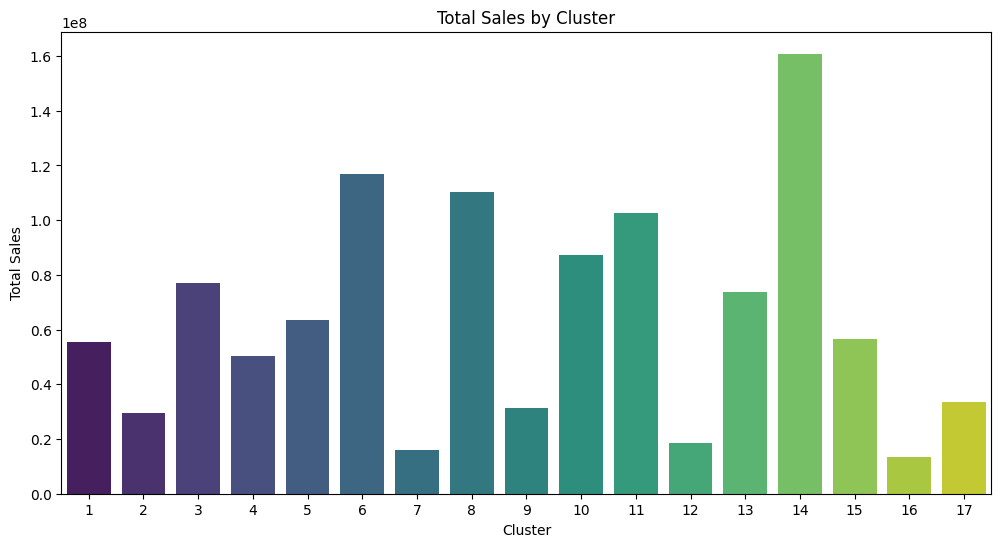

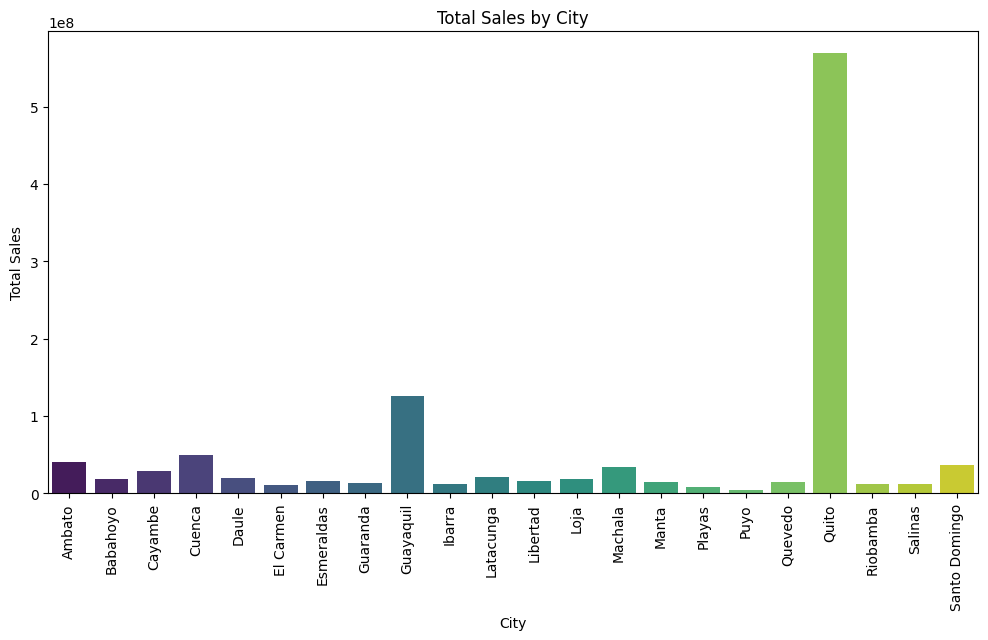

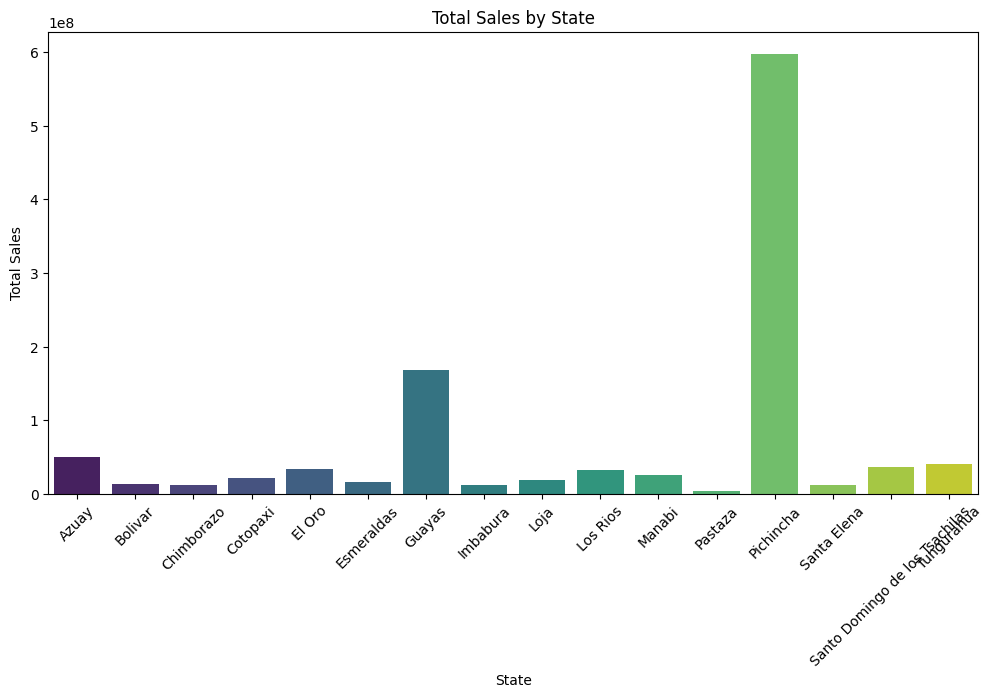

'type' column not found in the DataFrame


In [141]:
#Group by cluster and aggregate sales (only if 'cluster' column exists)
if 'cluster' in train_data_mrg_final.columns:
    sales_by_cluster = train_data_mrg_final.groupby('cluster')['sales'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='cluster', y='sales', data=sales_by_cluster, palette='viridis')
    plt.title('Total Sales by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Total Sales')
    plt.show()
else:
    print("'cluster' column not found in the DataFrame")

# Group by city and aggregate sales (only if 'city' column exists)
if 'city' in train_data_mrg_final.columns:
    sales_by_city = train_data_mrg_final.groupby('city')['sales'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='city', y='sales', data=sales_by_city, palette='viridis')
    plt.title('Total Sales by City')
    plt.xlabel('City')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("'city' column not found in the DataFrame")

# Group by state and aggregate sales (only if 'state' column exists)
if 'state' in train_data_mrg_final.columns:
    sales_by_state = train_data_mrg_final.groupby('state')['sales'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='state', y='sales', data=sales_by_state, palette='viridis')
    plt.title('Total Sales by State')
    plt.xlabel('State')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("'state' column not found in the DataFrame")

# Group by store type and aggregate sales (only if 'type' column exists)
if 'type' in train_data_mrg_final.columns:
    sales_by_type = train_data_mrg_final.groupby('type')['sales'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='type', y='sales', data=sales_by_type, palette='viridis')
    plt.title('Total Sales by Store Type')
    plt.xlabel('Store Type')
    plt.ylabel('Total Sales')
    plt.show()
else:
    print("'type' column not found in the DataFrame")

### **Question 6**

### **Are sales affected by promotions, oil prices, and holidays?**

Correlation between Sales and Oil Prices: -0.07939344970013977


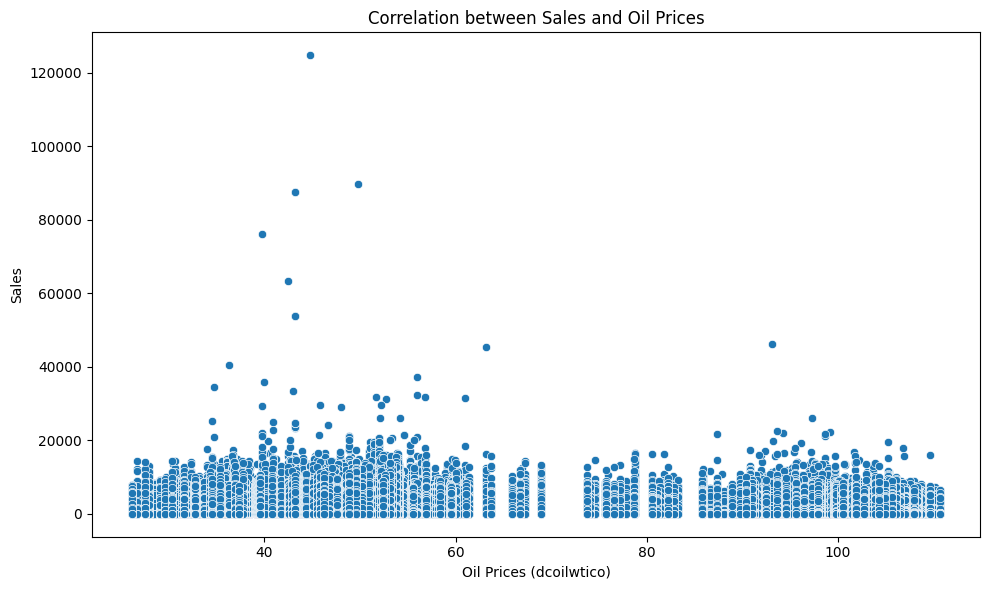

Correlation between Sales and Promotions: 0.4282410665192657


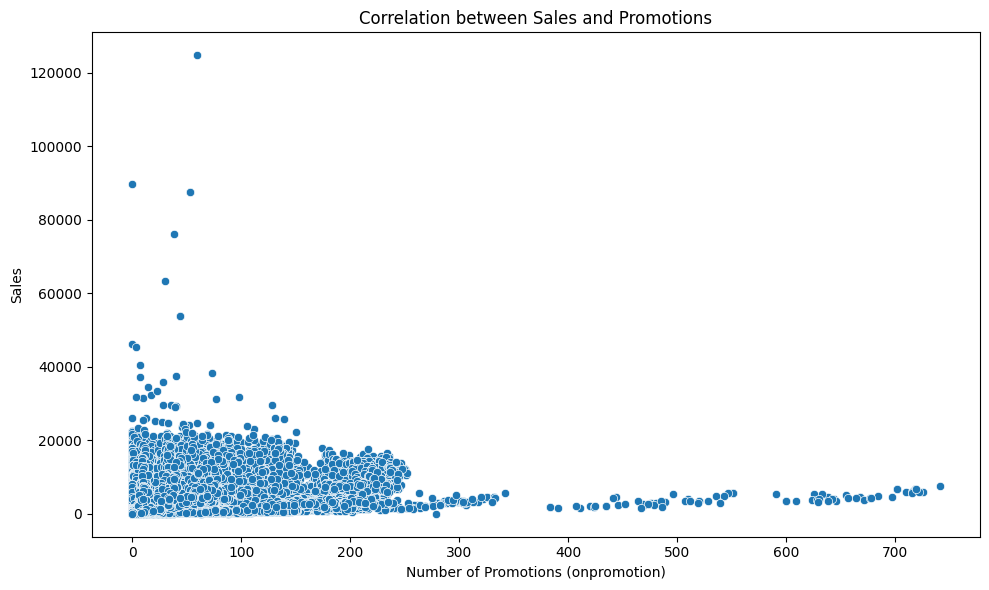

Column 'holiday' not found in the DataFrame.
T-statistic for promotions: 669.9966792269075, P-value: 0.0
Column 'holiday' not found in the DataFrame.


In [142]:
#Check and calculate the correlation between sales and oil prices
if 'sales' in train_data_mrg_final.columns and 'dcoilwtico' in train_data_mrg_final.columns:
    correlation_sales_oil = train_data_mrg_final['sales'].corr(train_data_mrg_final['dcoilwtico'])
    print("Correlation between Sales and Oil Prices:", correlation_sales_oil)
    
    # Create a scatter plot to visualize the correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train_data_mrg_final, x='dcoilwtico', y='sales')
    plt.title('Correlation between Sales and Oil Prices')
    plt.xlabel('Oil Prices (dcoilwtico)')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns for sales and oil prices correlation are missing.")

#Check and calculate the correlation between sales and promotions
if 'sales' in train_data_mrg_final.columns and 'onpromotion' in train_data_mrg_final.columns:
    correlation_sales_promotion =train_data_mrg_final['sales'].corr(train_data_mrg_final['onpromotion'])
    print("Correlation between Sales and Promotions:", correlation_sales_promotion)
    
    # Create a scatter plot to visualize the correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train_data_mrg_final, x='onpromotion', y='sales')
    plt.title('Correlation between Sales and Promotions')
    plt.xlabel('Number of Promotions (onpromotion)')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns for sales and promotions correlation are missing.")

#Check and group by holiday to compare sales if 'holiday' column exists
if 'holiday' in train_data_mrg_final.columns:
    sales_by_holiday = train_data_mrg_final.groupby('holiday')['sales'].mean().reset_index()
    print(sales_by_holiday)
    
    # Create a bar plot to visualize sales by holiday
    plt.figure(figsize=(10, 6))
    sns.barplot(data=sales_by_holiday, x='holiday', y='sales')
    plt.title('Average Sales by Holiday')
    plt.xlabel('Holiday')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'holiday' not found in the DataFrame.")

#Perform t-test for promotions if 'onpromotion' column exists
if 'onpromotion' in train_data_mrg_final.columns:
    promoted_sales = train_data_mrg_final[train_data_mrg_final['onpromotion'] > 0]['sales']
    non_promoted_sales = train_data_mrg_final[train_data_mrg_final['onpromotion'] == 0]['sales']
    
    t_stat, p_value = stats.ttest_ind(promoted_sales, non_promoted_sales)
    print(f"T-statistic for promotions: {t_stat}, P-value: {p_value}")
else:
    print("Column 'onpromotion' not found in the DataFrame.")

#Perform t-test for holidays if 'holiday' column exists and is binary (1 for holiday, 0 for non-holiday)
if 'holiday' in train_data_mrg_final.columns:
    if train_data_mrg_final['holiday'].nunique() == 2:
        holiday_sales = train_data_mrg_final[train_data_mrg_final['holiday'] == 1]['sales']
        non_holiday_sales = train_data_mrg_final[train_data_mrg_final['holiday'] == 0]['sales']
        
        t_stat_holiday, p_value_holiday = stats.ttest_ind(holiday_sales, non_holiday_sales)
        print(f"T-statistic for holidays: {t_stat_holiday}, P-value: {p_value_holiday}")
    else:
        print("Column 'holiday' is not binary.")
else:
    print("Column 'holiday' not found in the DataFrame.")


**Correlation between Sales and Oil Prices: -0.07939344970013977**

- 0.079 is close to zero, indicating a very weak negative relationship between sales and oil prices. This means that as oil prices change, there is almost no systematic effect on sales, and if there is any effect, it is very minimal.

**Correlation between Sales and Promotions: 0.4282410665192657**
 
- 0.428 suggests a moderate positive relationship between sales and promotions. This implies that as promotions increase, sales tend to increase as well, though the relationship is not perfect.

### **Question 7**

### **What analysis can we get from the date and its extractable features?**

Below 

>- 1.Seasonality Analysis: By extracting the month, quarter, or season from the date, you can analyze historical sales patterns and identify recurring seasonal trends. This information can help in predicting future sales during specific periods, such as holidays or seasonal promotions.

>- 2.Day of the Week Analysis: Extracting the day of the week can reveal sales patterns based on weekdays versus weekends. This analysis can help identify differences in customer behavior, such as higher sales on weekends or specific days when certain products or promotions perform better.

>- 3.Holiday and Event Analysis: Identifying holidays, festivals, or major events from the date can help predict sales spikes or lulls. By analyzing historical sales data during these periods, you can forecast future sales based on the impact of specific events and plan promotional strategies accordingly.

>- 4.Trend Analysis: By analyzing the sequential order of dates and sales data, you can identify overall trends and patterns. Techniques like moving averages or regression analysis can be applied to extract underlying trends and forecast future sales based on those trends.

### **Question 8**

### **Which product family and stores did the promotions affect?**

onpromotion                            0             1             2  \
family                                                                 
AUTOMOTIVE                  5.238380e+05  2.654700e+04  7.444000e+03   
BABY CARE                   1.024000e+04  9.000000e+01  0.000000e+00   
BEAUTY                      2.497250e+05  7.807600e+04  1.431500e+04   
BEVERAGES                   5.123755e+07  1.410454e+07  1.173791e+07   
BOOKS                       6.540000e+03  0.000000e+00  0.000000e+00   
BREAD/BAKERY                2.001600e+07  5.759759e+06  3.973689e+06   
CELEBRATION                 7.133000e+05  4.496400e+04  7.726000e+03   
CLEANING                    3.603135e+07  8.472528e+06  7.336795e+06   
DAIRY                       2.180675e+07  6.796430e+06  4.854499e+06   
DELI                        1.158522e+07  2.445099e+06  1.417630e+06   
EGGS                        1.001024e+07  2.520576e+06  8.704470e+05   
FROZEN FOODS                6.018586e+06  2.237512e+06  1.921137

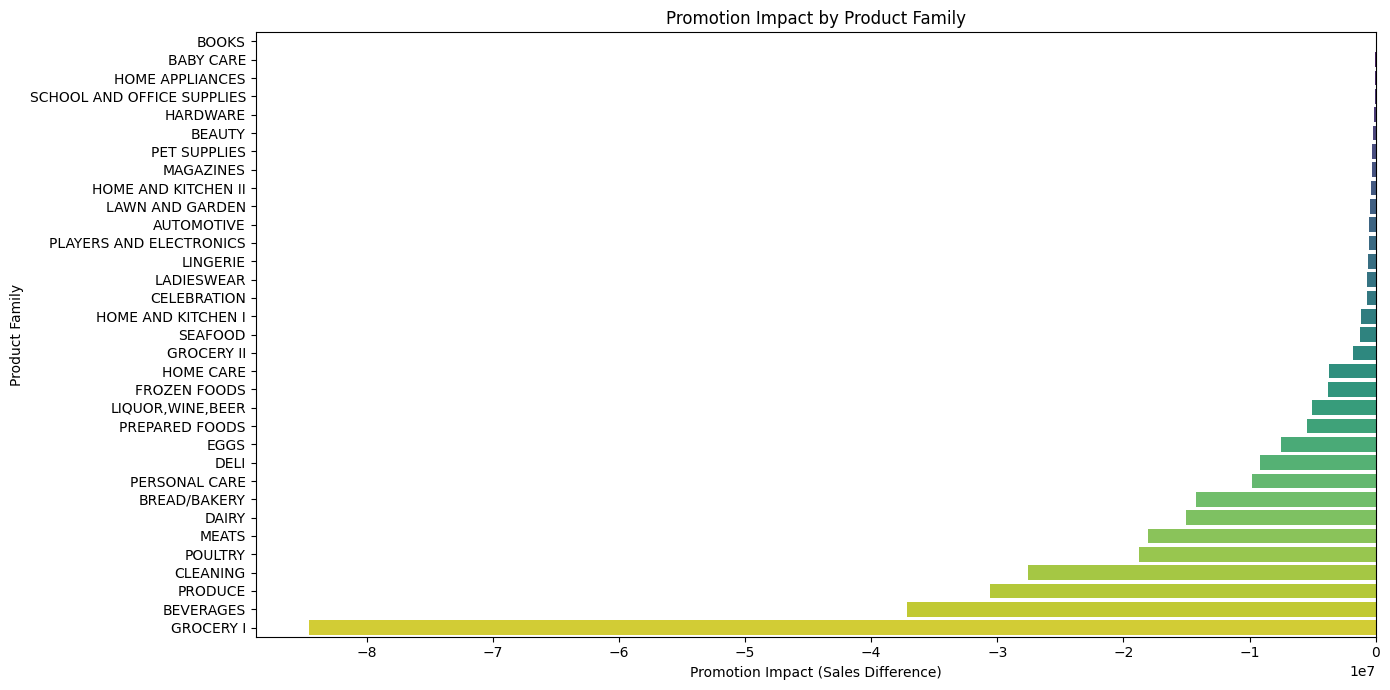

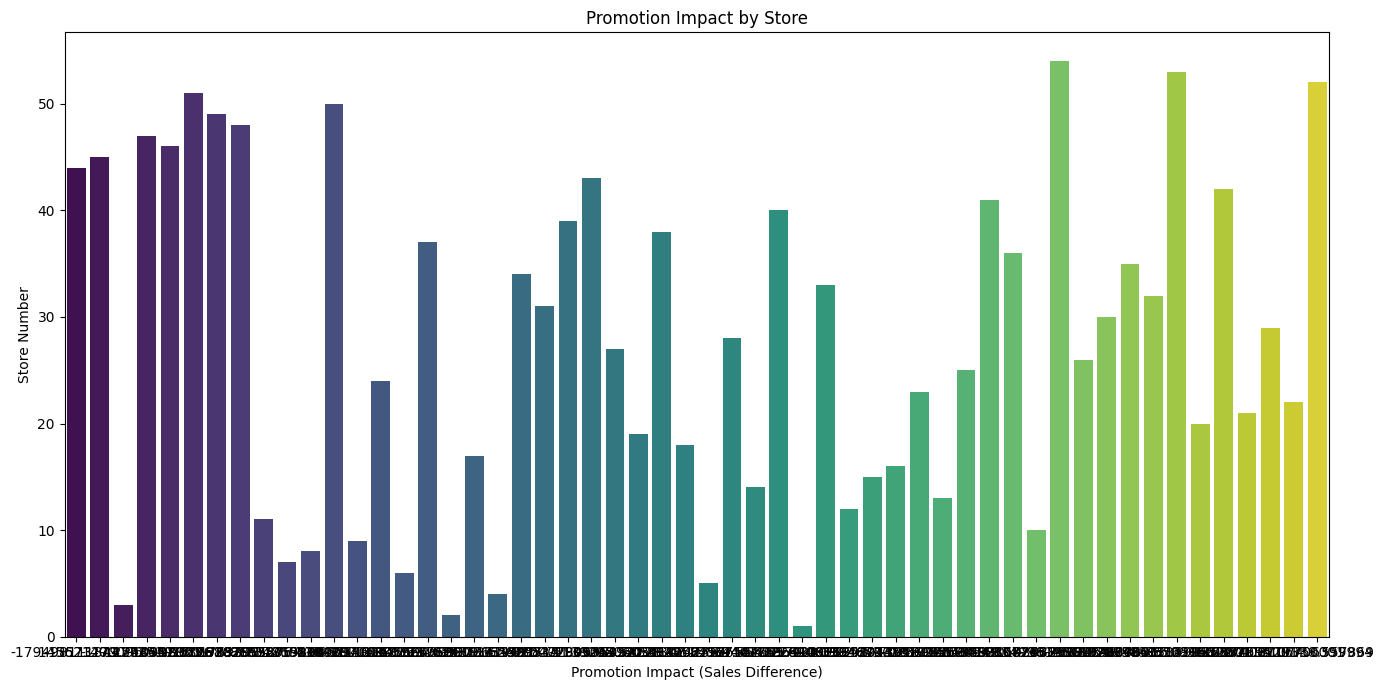

In [143]:
#Group by product family and calculate total sales for promoted and non-promoted products
sales_by_family_promotion =train_data_mrg_final.groupby(['family', 'onpromotion'])['sales'].sum().unstack().fillna(0)

#Group by store and calculate total sales for promoted and non-promoted products
sales_by_store_promotion = train_data_mrg_final.groupby(['store_nbr', 'onpromotion'])['sales'].sum().unstack().fillna(0)

#Calculate the promotion impact (e.g., difference in sales)
sales_by_family_promotion['promotion_impact'] = sales_by_family_promotion[1] - sales_by_family_promotion[0]
sales_by_store_promotion['promotion_impact'] = sales_by_store_promotion[1] - sales_by_store_promotion[0]

#Display the results
print(sales_by_family_promotion)
print(sales_by_store_promotion)

#Ensure promotion impact is calculated correctly
sales_by_family_promotion['promotion_impact'] = sales_by_family_promotion[1] - sales_by_family_promotion[0]

#Sort by promotion impact
sales_by_family_promotion_sorted = sales_by_family_promotion.sort_values(by='promotion_impact', ascending=False)

#Plot promotion impact by product family
plt.figure(figsize=(14, 7))
sns.barplot(x=sales_by_family_promotion_sorted['promotion_impact'], y=sales_by_family_promotion_sorted.index, palette='viridis')
plt.title('Promotion Impact by Product Family')
plt.xlabel('Promotion Impact (Sales Difference)')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()


#Ensure promotion impact is calculated correctly
sales_by_store_promotion['promotion_impact'] = sales_by_store_promotion[1] - sales_by_store_promotion[0]

#Sort by promotion impact
sales_by_store_promotion_sorted = sales_by_store_promotion.sort_values(by='promotion_impact', ascending=False)

#Plot promotion impact by store
plt.figure(figsize=(14, 7))
sns.barplot(x=sales_by_store_promotion_sorted['promotion_impact'], y=sales_by_store_promotion_sorted.index, palette='viridis')
plt.title('Promotion Impact by Store')
plt.xlabel('Promotion Impact (Sales Difference)')
plt.ylabel('Store Number')
plt.tight_layout()
plt.show()

### **Question 9**

### **What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)**

>- 1. **Mean Absolute Error (MAE)**
Definition: MAE measures the average magnitude of errors in a set of predictions, without considering their direction. It’s the average of the absolute differences between predicted values and actual values.

**Characteristics:**
- Robust to Outliers: Less sensitive to outliers compared to RMSE and MSE.
- Scale of Units: In the same units as the target variable, making it easy to interpret.

>- 2. **Mean Squared Error (MSE)**
Definition: MSE calculates the average of the squared differences between predicted values and actual values. It penalizes larger errors more than smaller ones.

**Characteristics**
- Sensitive to Outliers: Larger errors are heavily penalized due to squaring, which can be useful for catching significant deviations.
- Scale of Units: The result is in the squared units of the target variable, which can make interpretation less intuitive.

>- 3. **Root Mean Squared Error (RMSE)**
Definition: RMSE is the square root of MSE, bringing the error metric back to the same units as the target variable. It provides a measure of the average magnitude of errors, with the same sensitivity to outliers as MSE.
**Characteristics:**
- Sensitive to Outliers: Like MSE, it penalizes larger errors more significantly.
- Scale of Units: Same units as the target variable, making it easier to interpret compared to MSE.

>- 4. **Root Mean Squared Logarithmic Error (RMSLE)**
Definition: RMSLE measures the logarithmic difference between the actual and predicted values. It’s particularly useful when you want to compare relative error and handle cases where you want to mitigate the impact of large predictions.

**Characteristics:**
- Handles Exponential Growth: Useful for data where the target variable grows exponentially.
- Less Sensitive to Large Absolute Errors: Reduces the impact of large errors and is less sensitive to differences in the scale of the target variable.
- Non-Negative and Scale-Invariant: Provides a measure of error that is normalized and less affected by the scale of predictions.

**Summary of Differences**
- MAE is straightforward, averaging absolute errors and is robust to outliers.
- MSE and RMSE penalize larger errors more heavily due to squaring the errors. RMSE is in the same units as the target variable, making it easier to interpret than MSE.
- RMSLE is useful when the target variable can grow exponentially, and it minimizes the impact of large errors and different scales of predictions.

>- In summary, MAE might be greater than RMSE or MSE in some cases, particularly if the dataset contains many small errors where the absolute differences are larger than the squared errors. Conversely, RMSE and MSE might be larger if there are a few significant outliers or large errors. Each metric provides different insights and is suited to different contexts and types of data.

### **Question 10** 

### **Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales?**

In [144]:
# Verify null values before filling
print(train_data_mrg_final[['type_x', 'locale', 'locale_name', 'description']].isnull().sum())
print(train_data_mrg_final['transferred'].isnull().sum())

# Filling null values
train_data_mrg_final['type_x'].fillna('No Event', inplace=True)
train_data_mrg_final['locale'].fillna('No Event', inplace=True)
train_data_mrg_final['locale_name'].fillna('No Event', inplace=True)
train_data_mrg_final['description'].fillna('No Event', inplace=True)
train_data_mrg_final['transferred'].fillna(False, inplace=True)

# Verify null values after filling
print(train_data_mrg_final[['type_x', 'locale', 'locale_name', 'description']].isnull().sum())
print(train_data_mrg_final['transferred'].isnull().sum())






type_x         2551824
locale         2551824
locale_name    2551824
description    2551824
dtype: int64
2551824
type_x         0
locale         0
locale_name    0
description    0
dtype: int64
0


In [145]:
# Interpolate missing values
train_data_mrg_final['dcoilwtico'].interpolate(method='linear', inplace=True)

# Forward fill remaining NaNs
train_data_mrg_final['dcoilwtico'].fillna(method='ffill', inplace=True)

# Backward fill any remaining NaNs
train_data_mrg_final['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verify null values after filling
print(train_data_mrg_final['dcoilwtico'].isnull().sum())


0


In [146]:
# Fill null values in the 'transaction' column with 0
train_data_mrg_final['transactions'].fillna(0, inplace=True)

# Verify that there are no null values left in the 'transaction' column
print(train_data_mrg_final['transactions'].isnull().sum())


0


### **Data Preparation**

Using difference to achieve stationarity

Since the aim of this project is to forecast the overall sales for Favorita, we focus on aggregating and analyzing the total daily sales. To assess stationarity, the Augmented Dickey-Fuller (ADF) test will be employed.

In [147]:
#Calculate Sales Difference
train_data['sales_diff'] = train_data['sales'] - train_data['sales'].shift(1)

#Group by Date and Aggregate
diff_df = train_data.groupby('date').agg({'sales': 'sum', 'sales_diff': 'sum'}).reset_index()

# 3. Resample to Weekly and Calculate the Mean Sales Difference
resampled_df = diff_df.set_index('date').resample('W').agg({'sales_diff': 'mean'}).reset_index()

# Check the shape and content of the resulting DataFrame
print(resampled_df.shape)
print(resampled_df)


(242, 2)
          date  sales_diff
0   2013-01-06    6.092167
1   2013-01-13   -3.147714
2   2013-01-20    1.666714
3   2013-01-27    0.299143
4   2013-02-03    1.261714
..         ...         ...
237 2017-07-23   -0.066571
238 2017-07-30    0.291571
239 2017-08-06    0.728571
240 2017-08-13   -0.715571
241 2017-08-20   -2.000000

[242 rows x 2 columns]


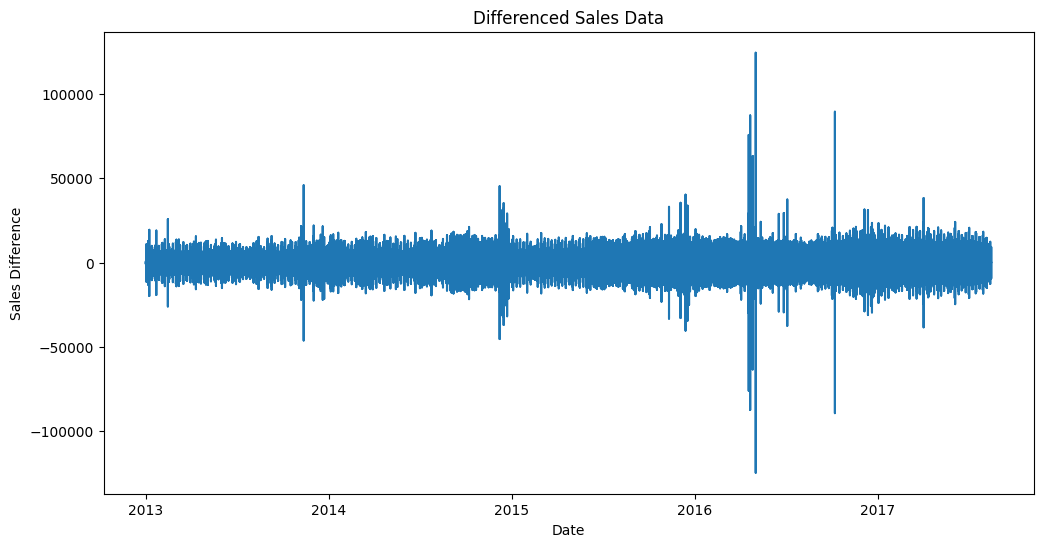

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['sales_diff'])
plt.title('Differenced Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.show()


In [149]:
#testing for stationarity using adfuller
result = adfuller(resampled_df['sales_diff'])
print(f'Test Statistics : {result[0]}')
print(f'p-values : {result[1]}')
print(f'critical values: {result[4]}')

if result[1] > 0.05:
    print('The series is not stationary')
else:
    print('The series is stationary')

Test Statistics : -11.131999769825107
p-values : 3.2646225713982116e-20
critical values: {'1%': -3.4582467982399105, '5%': -2.8738137461081323, '10%': -2.5733111490323846}
The series is stationary


In [150]:
# Set the horizon date
horizon = pd.Timestamp('2017-07-15')

# Filter data for training
train = diff_df[diff_df['date'] < horizon]

# Filter data for testing
test = diff_df[diff_df['date'] >= horizon]

# Check the resulting DataFrames
print("Training Set:")
print(train.head())

print("\nTesting Set:")
print(test.head())

Training Set:
        date          sales  sales_diff
0 2013-01-01    2511.618999       0.000
1 2013-01-02  496092.417944      29.214
2 2013-01-03  361461.231124      -4.214
3 2013-01-04  354459.677093     -14.000
4 2013-01-05  477350.121229      17.361

Testing Set:
           date         sales  sales_diff
1652 2017-07-15  9.690771e+05      20.463
1653 2017-07-16  1.100804e+06     -17.511
1654 2017-07-17  8.183255e+05      -8.187
1655 2017-07-18  7.301337e+05       0.053
1656 2017-07-19  7.679788e+05       3.289


In [151]:
train = train.drop(columns='sales_diff')
test = test.drop(columns='sales_diff')

### **Using Autoregressive Model**

An autoregressive (AR) model is used to predict future values of a time series variable based on its own past values. It operates on the premise that the current value of the time series is a linear combination of its previous values, along with some randomness or error term. AR models are often combined with other components, such as moving averages, to form more comprehensive time series models like ARIMA and SARIMA, which are capable of handling more complex time series patterns.

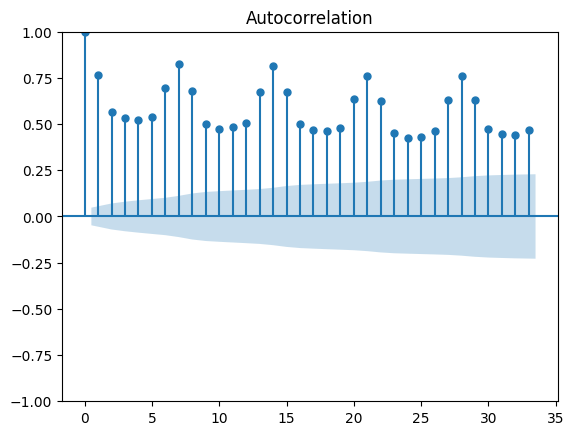

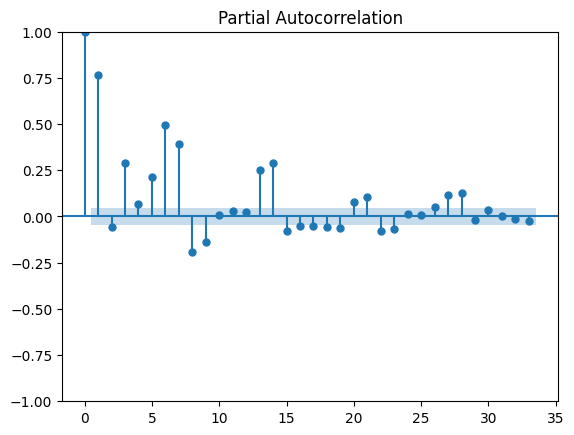

In [152]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_df['sales'].dropna())
plot_pacf(diff_df['sales'].dropna())
plt.show()


### **Using SARIMA, ARIMA and PROPHET models**

In [153]:
# Define the SARIMA order and seasonal order
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 7)

# Define the ARIMA order
arima_order = (1, 1, 1)

# Define the Prophet model parameters
prophet_params = {
    'changepoint_prior_scale': 0.1,
    'seasonality_prior_scale': 10,
}    

In [154]:
# Initialize lists to store evaluation metrics and forecast results
models = ['SARIMA', 'ARIMA']
# Creating dictionary for the trained models
all_stat_models = {}
forecast_data = {'SARIMA': None, 'ARIMA': None, 'Prophet': None}
mae_results = []
mse_results = []
rmse_results = []
rmsle_results = []

for model_name in models:
    print(f'Training {model_name}...')
    
    if model_name == 'SARIMA':
        model = SARIMAX(train['sales'], order=sarima_order, seasonal_order=sarima_seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(len(test))
    else:
    
        model = ARIMA(train['sales'], order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(len(test))
    
               
    # Store the sales forecast
    forecast_data[model_name] = forecast
    
    # Store the trained model 
    all_stat_models[model_name] = model_fit
    
    # Calculate metrics     
    mae = mean_absolute_error(test['sales'], forecast)
    mse = mean_squared_error(test['sales'], forecast)
    rmse = root_mean_squared_error(test['sales'], forecast)
    rmsle = root_mean_squared_log_error(test['sales'], forecast) 
 
    # rmsle_results.append(rmsle)
    mae_results.append(mae)
    mse_results.append(mse)
    rmse_results.append(rmse)
    rmsle_results.append(rmsle)
    
# Display evaluation results
eval_results = pd.DataFrame({
    'MODEL_NAME': models,        
    'MAE': mae_results,
    'MSE': mse_results,
    'RMSE': rmse_results,
    'RMSLE': rmsle_results,
})
print('\nEvaluation Results:')
eval_results

Training SARIMA...
Training ARIMA...

Evaluation Results:


MODEL_NAME            MAE           MSE           RMSE     RMSLE
0     SARIMA   62063.096294  8.872644e+09   94194.710594  0.105587
1      ARIMA  111809.017016  1.734441e+10  131698.170216  0.152662

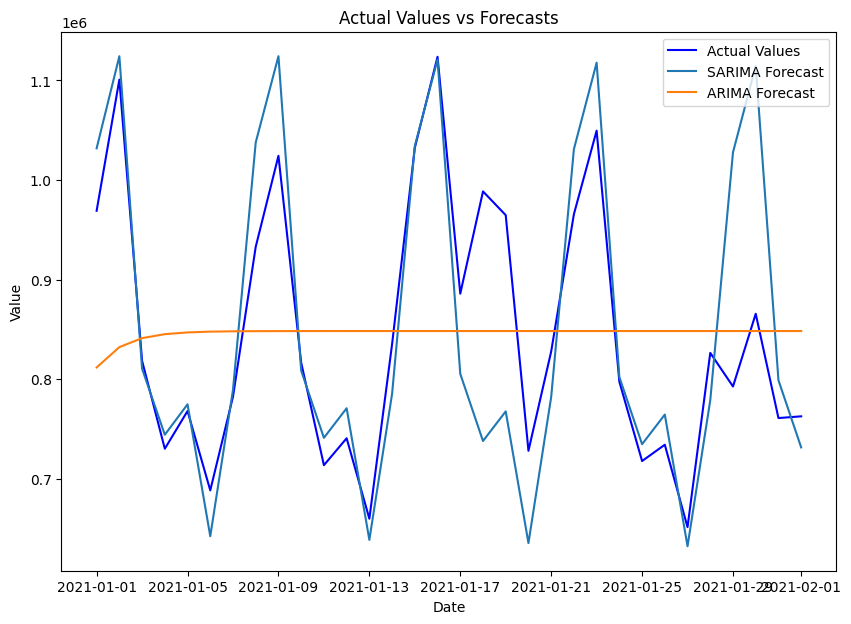

In [155]:
# Example data
date_range = pd.date_range(start='2021-01-01', periods=len(test), freq='D')

# Create DataFrames for actual values and forecasts
df_actual = pd.DataFrame({'Date': date_range, 'Actual': test['sales'].values})

# Plot
plt.figure(figsize=(10, 7))

# Plot actual values
plt.plot(df_actual['Date'], df_actual['Actual'], label='Actual Values', color='blue')

# Plot forecasts
for model_name in models:
    forecast = forecast_data[model_name]
    df_forecast = pd.DataFrame({'Date': date_range, f'{model_name}_Forecast': forecast})
    plt.plot(df_forecast['Date'], df_forecast[f'{model_name}_Forecast'], label=f'{model_name} Forecast')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Values vs Forecasts')
plt.legend()

# Show the plot
plt.show()


**Key Insights**

SARIMA outperforms ARIMA across all metrics (MAE, MSE, RMSE, RMSLE), indicating that SARIMA generally provides better predictions in terms of both average error and handling large errors.

#### Feature Encoding

- Label Encoder: I'll use a Label Encoder for the "transferred" column since it contains binary values, specifically "True" and "False."

- Ordinal Encoder: For the "locale" column, which represents hierarchical categories like "National" and "Local," I'll use an Ordinal Encoder to maintain the ordinal relationship between these categories.

- Binary Encoder: Lastly, I'll apply a Binary Encoder to the "holiday" column, which includes various categorical variables. This technique will help transform these categorical values into binary code representations efficiently.

### Split into X and y

In [156]:
train_data.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'sales_diff'], dtype='object')

In [157]:
train_data = train_data.drop(columns = ['sales_diff'])

In [158]:
train_data.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [159]:
train_data.head()

date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0            0
1 2013-01-01          1   BABY CARE    0.0            0
2 2013-01-01          1      BEAUTY    0.0            0
3 2013-01-01          1   BEVERAGES    0.0            0
4 2013-01-01          1       BOOKS    0.0            0

In [160]:
# Define feature columns
feature_columns = ['date', 'store_nbr', 'family', 'onpromotion']

# Define target variable
target = 'sales'

# Split data
X = train_data[feature_columns]
y = train_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
y_test = y_test.drop(columns='date')
y_train = y_train.drop(columns='date')

#### Create new features

In [162]:
def fix_col_types(X):
    X['store_nbr'] = X['store_nbr'].astype('object')
    X['family'] = X['family'].astype('object')
        
    return X

In [163]:
def create_promotion_feature(X):
    X['promotion'] = X['onpromotion'].apply(lambda x: 'Yes' if x>0 else 'No')
    
    return X.drop(columns='onpromotion')

In [164]:
def create_date_features(X):
    X['date'] = pd.to_datetime(X['date'])
    # Year
    X['year'] = X.date.dt.year       
    X['is_year_start']= X.date.dt.is_year_start.astype(int)
    # Quarter
    X['quarter']= X.date.dt.quarter
    X['is_quarter_start']= X.date.dt.is_quarter_start.astype(int)
    X['is_quarter_end']= X.date.dt.is_quarter_end.astype(int)
    # Month
    X['month'] = X.date.dt.month    
    X['is_month_start']= X.date.dt.is_month_start.astype(int)
    X['is_month_end']= X.date.dt.is_month_end.astype(int) 
    # Week  
    X['week_of_year'] = X.date.dt.isocalendar().week    
    X['is_weekend']= np.where(X.date.dt.dayofweek > 4, 1, 0)
    # Day
    X['day_of_year'] = X.date.dt.dayofyear 
    X['day_of_month'] = X.date.dt.day 
    X['day_of_week'] = X.date.dt.dayofweek   
               
    return X.drop(columns='date')

### Column names

In [165]:
# Date column
date_column = X.select_dtypes('datetime').columns

# Getting the categorical columns. Do categorical before numerical
categorical_columns = ['store_nbr', 'family', 'onpromotion']

# Getting the numerical columns
numerical_columns = ['date', 'onpromotion']

In [166]:
numerical_pipeline = Pipeline(steps=[
    ('date_features', FunctionTransformer(func=create_date_features)),
    ('num_imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),    
    ('num_scaler', RobustScaler())
])
 
# Define categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('fix_col_types', FunctionTransformer(func=fix_col_types)),
    ('promotion_features', FunctionTransformer(func=create_promotion_feature)),
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),        
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))
])
 
# Define ColumnTransformer
preprocessor = ColumnTransformer(transformers=[  
    ('cat', categorical_pipeline, categorical_columns),     
    ('num', numerical_pipeline, numerical_columns),       
])

In [167]:
# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Training Baseline...
Evaluation Results for Baseline:
MAE: 514.3427093232333
MSE: 1242817.4736133465
RMSE: 1114.8172377629198
RMSLE: 4.000911487442056


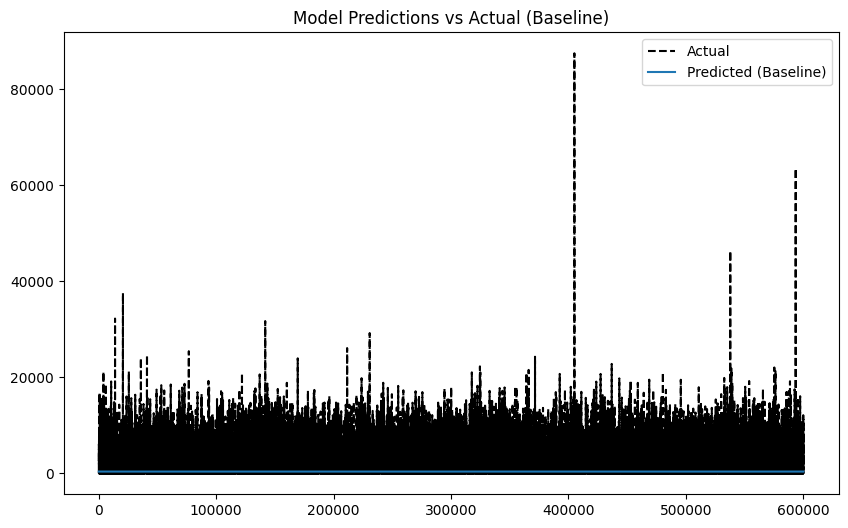

Training LinearRegression...
Evaluation Results for LinearRegression:
MAE: 314.70305451639894
MSE: 525932.3568517063
RMSE: 725.2119392644513
RMSLE: 3.314305253710843


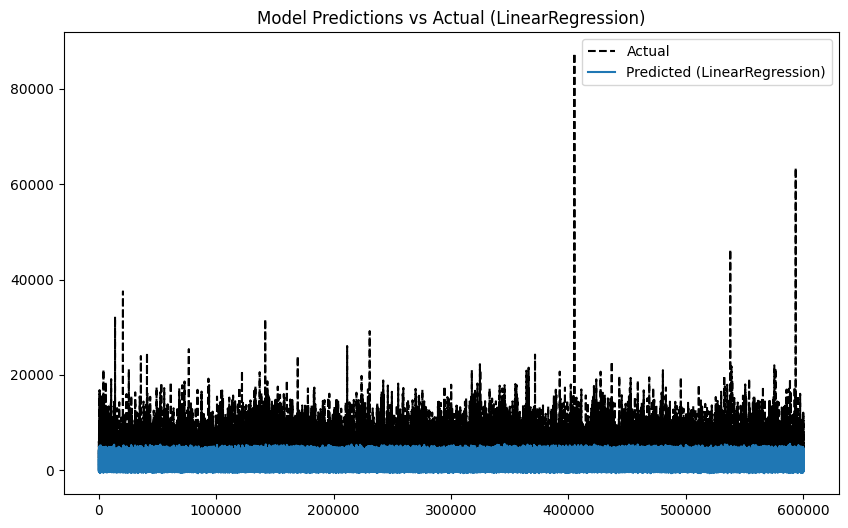

Training XGBoost...
Evaluation Results for XGBoost:
MAE: 114.26667129163303
MSE: 115282.29501958517
RMSE: 339.53246533959776
RMSLE: 2.349721421658152


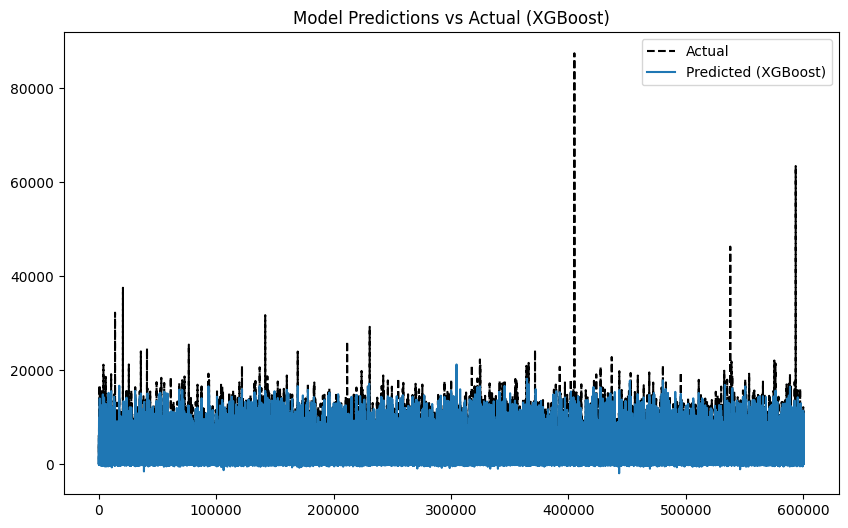

In [168]:
# Initialize models
models = {
    'Baseline': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    print(f'Training {model_name}...')
    model.fit(X_train_processed, y_train)
    predictions = model.predict(X_test_processed)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse =  root_mean_squared_error(y_test, predictions)
    # Apply the absolute value function to the y_pred
    pred_abs = abs(predictions)

    # Calculate the Root Mean Squared Logarithmic Error (RMSLE)
    rmsle = root_mean_squared_log_error(y_test, pred_abs)
    
    # Print results
    print(f'Evaluation Results for {model_name}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'RMSLE: {rmsle}')
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual', color='black', linestyle='--')
    plt.plot(predictions, label=f'Predicted ({model_name})')
    plt.legend()
    plt.title(f'Model Predictions vs Actual ({model_name})')
    plt.show()

# Train and evaluate each model separately
for model_name, model in models.items():
    train_and_evaluate(model, model_name)


Training Baseline...


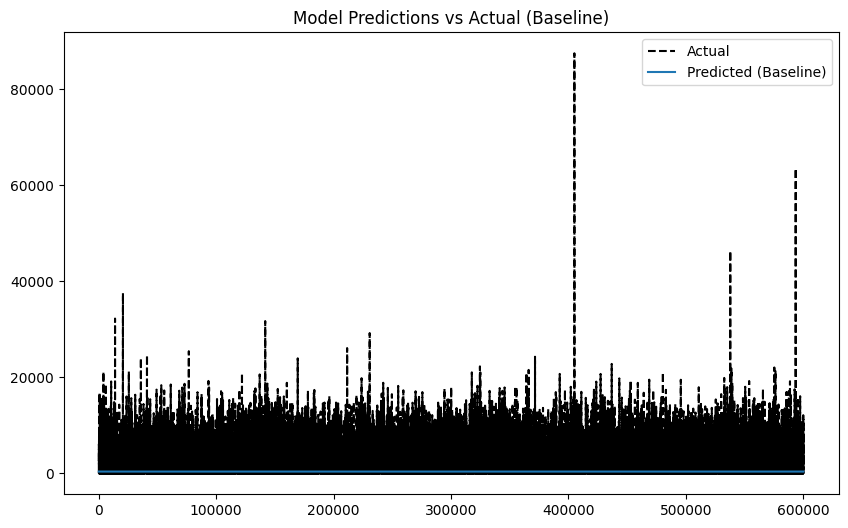

Training LinearRegression...


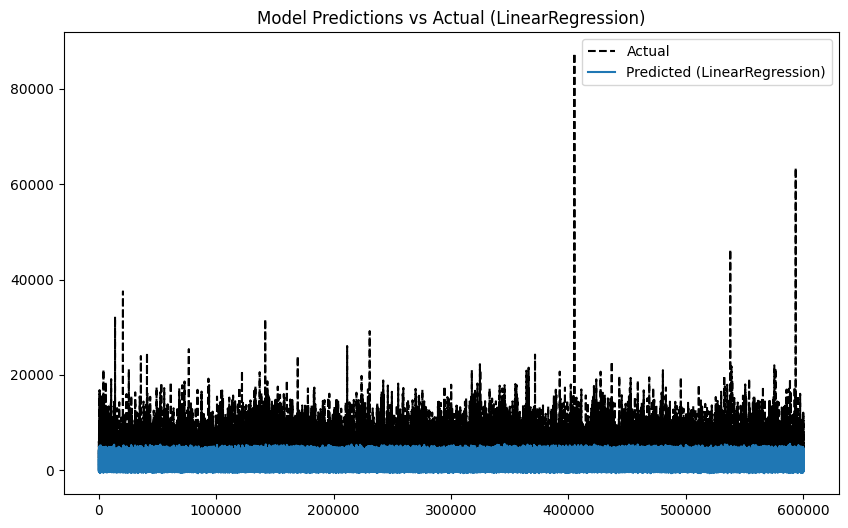

Training XGBoost...


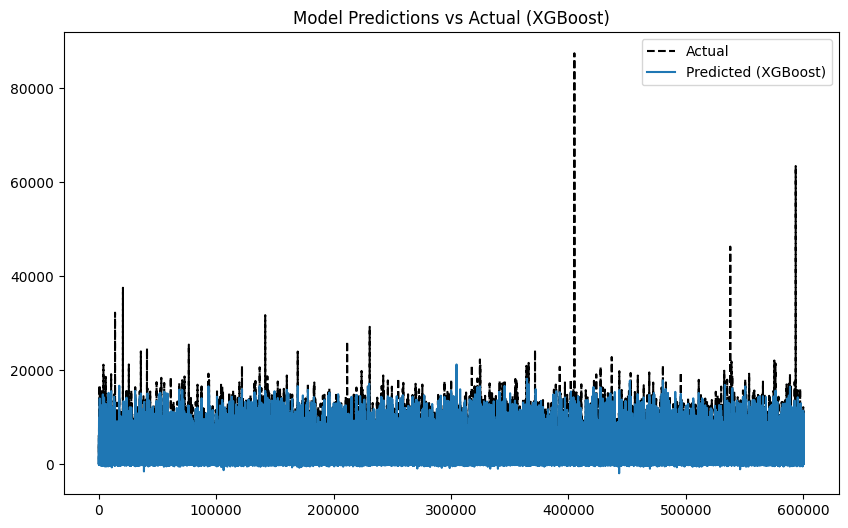

         MODEL_NAME         MAE           MSE         RMSE     RMSLE
0          Baseline  514.342709  1.242817e+06  1114.817238  4.000911
1  LinearRegression  314.703055  5.259324e+05   725.211939  3.314305
2           XGBoost  114.266671  1.152823e+05   339.532465  2.349721


In [169]:
# Define models
models = {
    'Baseline': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Initialize a list to store metrics DataFrames for each model
metrics_list = []

# Function to train and evaluate a model
def train_and_evaluate(model, model_name):
    print(f'Training {model_name}...')
    model.fit(X_train_processed, y_train)
    predictions = model.predict(X_test_processed)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_log_error(y_test, np.abs(predictions)))
    
    # Create a DataFrame with the metrics
    metrics_df = pd.DataFrame({
        'MODEL_NAME': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'RMSLE': [rmsle]
    })
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual', color='black', linestyle='--')
    plt.plot(predictions, label=f'Predicted ({model_name})')
    plt.legend()
    plt.title(f'Model Predictions vs Actual ({model_name})')
    plt.show()
    
    return metrics_df

# Train and evaluate each model separately and store the results
for model_name, model in models.items():
    metrics = train_and_evaluate(model, model_name)
    metrics_list.append(metrics)

# Concatenate all the metrics DataFrames into a single DataFrame
metrics_table_ml_models = pd.concat(metrics_list, ignore_index=True)

# Display the metrics table
print(metrics_table_ml_models)

### **Metrics Explanation:**
 - **MAE (Mean Absolute Error):**

This metric measures the average absolute difference between the predicted and actual values.
Lower is better.
It is less sensitive to outliers compared to MSE and RMSE.
Interpretation:

The XGBoost model has the lowest MAE (114.27), indicating it has the smallest average error in its predictions.
Linear Regression has a higher MAE (314.70), while the Baseline model has the highest MAE (514.34).

- **MSE (Mean Squared Error):**

This metric measures the average squared difference between the predicted and actual values.
Lower is better.
It penalizes larger errors more than smaller errors due to the squaring of differences.
Interpretation:

XGBoost has the lowest MSE (115,282.30), indicating that it has the least variance in its errors.
Linear Regression has a higher MSE (525,932.40), and the Baseline model has the highest MSE (1,242,817.00).

- **RMSE (Root Mean Squared Error):**

This is the square root of the MSE, providing an error metric in the same units as the original data.
Lower is better.
It is useful for understanding the error magnitude.
Interpretation:

XGBoost has the lowest RMSE (339.53), meaning its typical prediction error is smaller compared to the other models.
Linear Regression has a higher RMSE (725.21), while the Baseline model has the highest RMSE (1,114.82).

- **RMSLE (Root Mean Squared Logarithmic Error):**

This metric measures the ratio of the predicted to actual values, penalizing underestimations more than overestimations.
Lower is better.
It is useful for datasets with exponential growth or when you care more about the relative error.
Interpretation:

XGBoost has the lowest RMSLE (2.35), indicating it performs better at capturing the log-transformed patterns in the data.
Linear Regression has a higher RMSLE (3.31), and the Baseline model has the highest RMSLE (4.00).

- **Overall Interpretation:**
XGBoost outperforms both the Baseline and Linear Regression models across all metrics (MAE, MSE, RMSE, RMSLE). This suggests that XGBoost is the best model among the three for predicting sales in the Favorita dataset.
Linear Regression performs better than the Baseline model but is not as effective as XGBoost. It has lower errors than the Baseline model but higher errors than XGBoost.
The Baseline model, which uses the mean of the training data for predictions, performs the worst. This result highlights the importance of using more sophisticated models to capture the underlying patterns in the data.

In [170]:
print(metrics_table_ml_models)

         MODEL_NAME         MAE           MSE         RMSE     RMSLE
0          Baseline  514.342709  1.242817e+06  1114.817238  4.000911
1  LinearRegression  314.703055  5.259324e+05   725.211939  3.314305
2           XGBoost  114.266671  1.152823e+05   339.532465  2.349721


In [171]:
print('\nEvaluation Results:')
eval_results


Evaluation Results:


MODEL_NAME            MAE           MSE           RMSE     RMSLE
0     SARIMA   62063.096294  8.872644e+09   94194.710594  0.105587
1      ARIMA  111809.017016  1.734441e+10  131698.170216  0.152662

In [172]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

P = D = Q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, D, Q))]


In [173]:
# Save the trained model
with open('sarima_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)

In [174]:
# Load the new test dataset
test_data = pd.read_csv(r'C:\Users\hp\Desktop\lp3\Time-series-Regression-Analysis\datasets\test.csv')
#converting to datetime format
test_data['date'] = pd.to_datetime(test_data['date'],format = '%Y-%m-%d')
#the id column wont be necessary for our analysis
test_data = test_data.drop(['id'], axis = 1)


In [175]:
test_data.columns

Index(['date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [180]:
# Load the trained SARIMA model (assuming you saved it as 'sarima_model.pkl')
with open('sarima_model.pkl', 'rb') as file:
    trained_model = pickle.load(file)

# Make predictions with the new test dataset
# Ensure the length of the new dataset is correct for forecasting
forecast_steps = len(test_data)
forecast = trained_model.get_forecast(steps=forecast_steps).predicted_mean

# Save the forecast to a CSV file
forecast_df = pd.DataFrame({'date': test_data.index, 'forecast': forecast})
forecast_df.to_csv('sarima_forecast_future.csv', index=False)

# Print or view the forecast
print(forecast_df)

        date       forecast
1652       0  811753.232652
1653       1  832176.740199
1654       2  841192.889461
1655       3  845173.153249
1656       4  846930.278088
...      ...            ...
30159  28507  848319.074637
30160  28508  848319.074637
30161  28509  848319.074637
30162  28510  848319.074637
30163  28511  848319.074637

[28512 rows x 2 columns]
